## Project 1 | Perceptron & Adaline on Adult Dataset

In [ ]:
# ===== Imports =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score


In [ ]:
# ===== Custom implementations =====
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)


class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                loss = self._update_weights(xi, target)
                losses.append(loss)
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def _shuffle(self, X, y):
        idx = np.random.permutation(len(y))
        return X[idx], y[idx]

    def _update_weights(self, xi, target):
        output = self.net_input(xi)
        error = target - output
        self.w_ += self.eta * xi * error
        self.b_ += self.eta * error
        return (error ** 2) / 2.0

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [ ]:
# ===== Load raw data =====
df_train_raw = pd.read_csv("project_adult.csv")
df_val_raw = pd.read_csv("project_validation_inputs.csv")

# Drop index column if present
for df in [df_train_raw, df_val_raw]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

# Separate features and target
X = df_train_raw.drop(columns=["income"])
y = (df_train_raw["income"] == ">50K").astype(int)

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ===== Preprocessing =====
categorical_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "sex", "native-country"
]
numeric_cols = [
    "age", "fnlwgt", "education-num",
    "capital-gain", "capital-loss", "hours-per-week"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Fit on training, transform train/test/validation
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
X_val = preprocessor.transform(df_val_raw)

# Convert sparse matrices to dense if needed
if hasattr(X_train, "toarray"):
    X_train = X_train.toarray()
    X_test = X_test.toarray()
    X_val = X_val.toarray()

print("Data shapes:", X_train.shape, X_test.shape, X_val.shape)

Data shapes: (20838, 107) (5210, 107) (6513, 107)


In [ ]:
# ===== Grid search for Perceptron =====
eta_list = [0.001, 0.01, 0.1]
n_iter_list = [10, 20, 50]
best_score_ppn, best_params_ppn = 0, None

for eta in eta_list:
    for n_iter in n_iter_list:
        ppn = Perceptron(eta=eta, n_iter=n_iter, random_state=1)
        ppn.fit(X_train, y_train.values)
        y_pred = ppn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Perceptron eta={eta}, n_iter={n_iter} -> acc={acc:.4f}")
        if acc > best_score_ppn:
            best_score_ppn, best_params_ppn = acc, (eta, n_iter)

print("Best Perceptron params:", best_params_ppn, "with acc:", best_score_ppn)

Perceptron eta=0.001, n_iter=10 -> acc=0.7731
Perceptron eta=0.001, n_iter=20 -> acc=0.8052
Perceptron eta=0.001, n_iter=50 -> acc=0.8019
Perceptron eta=0.01, n_iter=10 -> acc=0.7678
Perceptron eta=0.01, n_iter=20 -> acc=0.8152
Perceptron eta=0.01, n_iter=50 -> acc=0.7902
Perceptron eta=0.1, n_iter=10 -> acc=0.7213
Perceptron eta=0.1, n_iter=20 -> acc=0.7616
Perceptron eta=0.1, n_iter=50 -> acc=0.7491
Best Perceptron params: (0.01, 20) with acc: 0.8151631477927064


In [ ]:
# ===== Grid search for Adaline =====
eta_list = [0.0001, 0.0005, 0.001]
n_iter_list = [10, 20, 50]
best_score_ada, best_params_ada = 0, None

for eta in eta_list:
    for n_iter in n_iter_list:
        ada = AdalineSGD(eta=eta, n_iter=n_iter, random_state=1)
        ada.fit(X_train, y_train.values)
        y_pred = ada.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Adaline eta={eta}, n_iter={n_iter} -> acc={acc:.4f}")
        if acc > best_score_ada:
            best_score_ada, best_params_ada = acc, (eta, n_iter)

print("Best Adaline params:", best_params_ada, "with acc:", best_score_ada)

Adaline eta=0.0001, n_iter=10 -> acc=0.4499
Adaline eta=0.0001, n_iter=20 -> acc=0.4559
Adaline eta=0.0001, n_iter=50 -> acc=0.4499
Adaline eta=0.0005, n_iter=10 -> acc=0.4131
Adaline eta=0.0005, n_iter=20 -> acc=0.4296
Adaline eta=0.0005, n_iter=50 -> acc=0.4981
Adaline eta=0.001, n_iter=10 -> acc=0.4250
Adaline eta=0.001, n_iter=20 -> acc=0.4814
Adaline eta=0.001, n_iter=50 -> acc=0.4620
Best Adaline params: (0.0005, 50) with acc: 0.4980806142034549


In [134]:
# ==== Re-train best models for learning curves ====

# Perceptron best
ppn_best = Perceptron(eta=0.01, n_iter=20, random_state=1)
ppn_best.fit(X_train, y_train.values)

# Adaline best
ada_best = AdalineSGD(eta=0.0005, n_iter=50, random_state=1)
ada_best.fit(X_train, y_train.values)


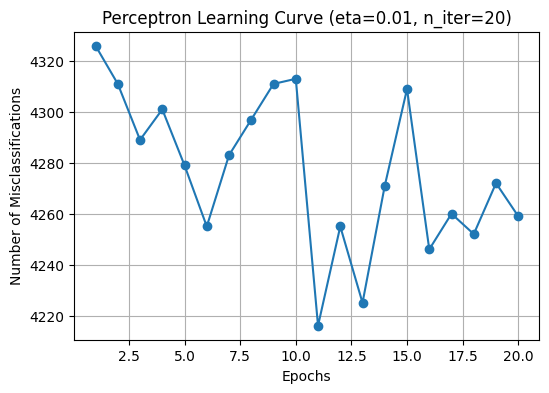

In [135]:

# ==== Plot Perceptron learning curve ====
plt.figure(figsize=(6,4))
plt.plot(range(1, len(ppn_best.errors_) + 1), ppn_best.errors_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Number of Misclassifications")
plt.title("Perceptron Learning Curve (eta=0.01, n_iter=20)")
plt.grid(True)
plt.show()


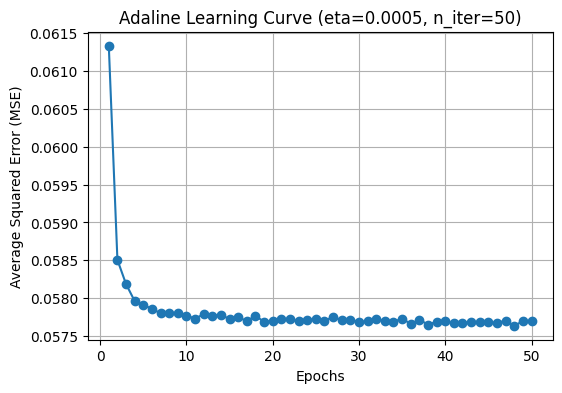

In [136]:

# ==== Plot Adaline learning curve ====
plt.figure(figsize=(6,4))
plt.plot(range(1, len(ada_best.losses_) + 1), ada_best.losses_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Average Squared Error (MSE)")
plt.title("Adaline Learning Curve (eta=0.0005, n_iter=50)")
plt.grid(True)
plt.show()


In [ ]:
# ===== Validation predictions =====
val_pred_ppn = ppn_best.predict(X_val)
val_pred_ada = ada_best.predict(X_val)

pd.DataFrame(val_pred_ppn, columns=["prediction"]).to_csv("Group_29_Perceptron_PredictedOutputs.csv", index=False)
pd.DataFrame(val_pred_ada, columns=["prediction"]).to_csv("Group_29_Adaline_PredictedOutputs.csv", index=False)

print("Validation prediction files created:")
print(" - Group_29_Perceptron_PredictedOutputs.csv")
print(" - Group_29_Adaline_PredictedOutputs.csv")


Validation prediction files created:
 - Group_29_Perceptron_PredictedOutputs.csv
 - Group_29_Adaline_PredictedOutputs.csv
